In [1]:
import numpy as np         
import pandas as pd
import edward as ed
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.colors as colors

%matplotlib inline

/Users/mortonjt/miniconda3/envs/phylogenetic-regression/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/mortonjt/miniconda3/envs/phylogenetic-regression/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


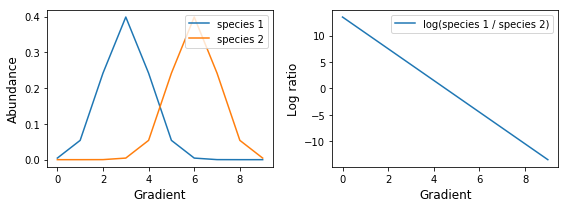

In [2]:
from bayesian_regression.util.sim import chain_interactions
num_samples = 10
num_features = 5
g = np.linspace(0, 9, num_samples)   # gradient values
mu = [3, 6]                 # means of species abundance gaussian distributions
sigma = [1, 1]              # variances of species abundance gaussian distribution
x = chain_interactions(g, mu, sigma)

# Plot the distributions and log-ratio
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
ax1.plot(g, x[:, 0], label='species 1') 
ax1.plot(g, x[:, 1], label='species 2')
ax2.plot(g, np.log(x[:, 0] / x[:, 1]), label='log(species 1 / species 2)')
ax1.legend() 
ax2.legend()
ax1.set_xlabel('Gradient', fontsize=12)
ax1.set_ylabel('Abundance', fontsize=12)
ax2.set_xlabel('Gradient', fontsize=12)
ax2.set_ylabel('Log ratio', fontsize=12)
plt.tight_layout()

Text(0.5,1,'Simulation')

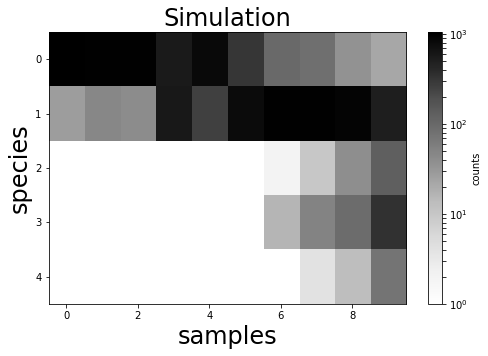

In [3]:
from bayesian_regression.util.generators import band_table
from bayesian_regression.util.balances import sparse_balance_basis, match_tips
from skbio.stats.composition import _gram_schmidt_basis
from scipy.sparse import coo_matrix
from gneiss.cluster import random_linkage

# Build basis for the ilr transform. 
basis = coo_matrix(_gram_schmidt_basis(num_features), dtype=np.float32).T

res = band_table(num_samples, num_features, tree=None,
                 mu=5, sigma=2, low=2, high=8,
                 spread=1, feature_bias=1, alpha=7, seed=0)
table, metadata, feature_metadata, sim_beta, sim_theta, sim_gamma = res

# Plot the heatmap of the counts
fig = plt.figure(figsize=(8, 5))
plt.imshow(table.matrix_data.todense(), aspect='auto', cmap='Greys', norm=colors.LogNorm())
plt.colorbar(label='counts')
plt.ylabel('species', fontsize=24)
plt.xlabel('samples', fontsize=24)
plt.title('Simulation', fontsize=24) 

In [4]:
table

5 x 10 <class 'biom.table.Table'> with 35 nonzero entries (70% dense)

In [5]:
from gneiss.regression._poisson import poisson_ols
model = poisson_ols('G', table, metadata, batch_size=12, seed=0)

1000/1000 [100%] ██████████████████████████████ Elapsed: 1s | Loss: 54.767


In [6]:
sess = ed.get_session()
model.qB.eval(session=sess)

array([[-0.42114484, -0.14152822,  0.8636342 ,  0.6733759 ]],
      dtype=float32)

In [7]:
model.qtheta.eval(session=sess)

array([[ 2.4314125e+00],
       [-9.6548976e-23],
       [-1.2869763e-01],
       [-3.2601155e-02],
       [-8.9476071e-04],
       [ 2.4937815e-04],
       [-1.1222001e-01],
       [-2.0178803e-03],
       [-2.2661078e-01],
       [-1.6405735e+00]], dtype=float32)

In [8]:
model.qgamma.eval(session=sess)

array([[3.3982987, 1.5410572, 2.0590074, 1.5908878]], dtype=float32)

In [9]:
model.qalpha.eval(session=sess)

0.4301655